# Ablation Test

En esta notebook haremos un test de ablación para ver qué componentes realmente aportan

["Understanding hidden memories of recurrent neural networks"](https://arxiv.org/abs/1710.10777)

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
import random
import torch

torch.manual_seed(2019)
np.random.seed(2019)
tf.random.set_random_seed(2019)
random.seed(2019)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

df_dev = pd.read_table("../../../data/es/dev_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/es/train_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_test = pd.read_table("../../../data/es/reference_es.tsv", header=None, 
                        names=["text", "HS", "TR", "AG"], quoting=csv.QUOTE_NONE)


text_train, y_train = df_train["text"], df_train["HS"]
text_dev, y_dev = df_dev["text"], df_dev["HS"]
text_test, y_test = df_test["text"], df_test["HS"]

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))
print("Instancias de test: {}".format(len(df_test)))


Instancias de entrenamiento: 4500
Instancias de desarrollo: 500
Instancias de test: 1600


Cargamos datos dev con anotaciones propias

In [2]:
df_dev = pd.read_csv("dev_with_annotations.es.csv", index_col="id")

df_dev = df_dev[df_dev["text"].notnull()]


Cargamos modelos de fasttext y ELMo

In [3]:
%%capture
from elmoformanylangs import Embedder
import fastText
import os


fasttext_model = fastText.load_model(os.path.expanduser("../../../WordVectors/UBA_w3_300.bin"))
elmo_embedder = Embedder("../../../models/elmo/es/")

## ELMO + FastText

We use a model with a BiLSTM + an average pooling (this is controlled by the `pooling` argument to the ElmoModel)

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Elmo (InputLayer)               (None, 50, 1024)     0                                            
__________________________________________________________________________________________________
Fasttext (InputLayer)           (None, 50, 300)      0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 50, 1324)     0           Elmo[0][0]                       
                                                                 Fasttext[0][0]                   
__________________________________________________________________________________________________
cu_dnngru_1 (CuDNNGRU)          (None, 50, 256)      1214976     concatenate_1[0][0]              
__________

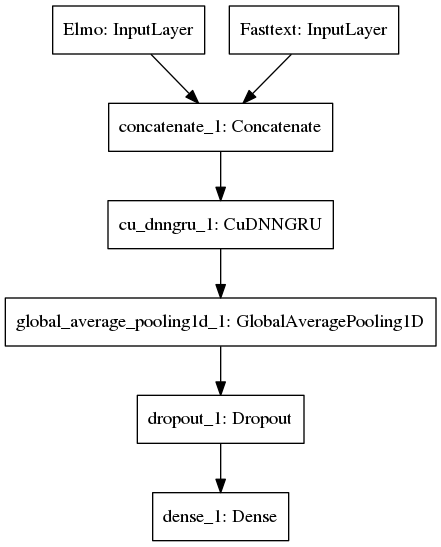

In [4]:
from hate.nn import ElmoConvexModel, ElmoModel
from keras.optimizers import Adam, rmsprop, SGD
from keras.layers import LSTM, GRU, CuDNNLSTM, CuDNNGRU
from keras.utils import plot_model
from IPython.display import Image

max_length = 50


def MyRecClass(*args, **kwargs):
    kwargs.update({
        'activation': 'sigmoid'
    })
    
    return GRU(*args, **kwargs)

classifier_args = {
    "dropout": 0.55,
    "rnn_units": 256,
    "recursive_class": CuDNNGRU,
    "bidirectional": False,
    "pooling": 'avg',
    "tokenize_args": {
        "preserve_case": False,
        "deaccent": False,
        "reduce_len": True,
        "strip_handles": True,
        "alpha_only": False,
        "stem": False
    }
}

optimizer_args = {
    "lr": 0.00075,
    "decay": 0.01,
}

optimizer = Adam



model = ElmoModel(
    max_length,  
    **{
        **classifier_args,
        **{
            "fasttext_model": fasttext_model,
            "elmo_embedder": elmo_embedder,
        }
    }
)


model.compile(loss='binary_crossentropy', 
              optimizer=optimizer(**optimizer_args), 
              metrics=['accuracy'])

#model.load_weights("../../../models/lstm_elmo.h5")
print(model.summary())
plot_model(model, to_file='model.png')


Image(filename='model.png') 

¿Cómo anda el tokenizador?

In [5]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint('/tmp/lstm_model.h5', save_best_only=True, monitor='val_acc', verbose=1)
early_stopper = EarlyStopping(monitor='val_acc', patience=10)


model.fit(text_train, y_train, 
          callbacks=[checkpointer, early_stopper],
          validation_data=(text_dev, y_dev), 
          epochs=100, verbose=1,
          batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 4s 905us/step - loss: 0.6697 - acc: 0.6302 - val_loss: 0.5445 - val_acc: 0.7280

Epoch 00001: val_acc improved from -inf to 0.72800, saving model to /tmp/lstm_model.h5
Epoch 2/100
4500/4500 [==============================] - 2s 346us/step - loss: 0.4917 - acc: 0.7629 - val_loss: 0.4397 - val_acc: 0.8140

Epoch 00002: val_acc improved from 0.72800 to 0.81400, saving model to /tmp/lstm_model.h5
Epoch 3/100
4500/4500 [==============================] - 2s 365us/step - loss: 0.4270 - acc: 0.8069 - val_loss: 0.4370 - val_acc: 0.8080

Epoch 00003: val_acc did not improve from 0.81400
Epoch 4/100
4500/4500 [==============================] - 2s 368us/step - loss: 0.3809 - acc: 0.8309 - val_loss: 0.4227 - val_acc: 0.8000

Epoch 00004: val_acc did not improve from 0.81400
Epoch 5/100
4500/4500 [==============================] - 2s 346us/step - loss: 0.3484 - acc: 0.8444 - val_loss: 0.4266 - val

In [6]:
from hate.utils import print_evaluation
print("{} -- \n\n".format(model.display_name))
print("Evaluación sobre dev")

model.load_weights(checkpointer.filepath)

print_evaluation(model, text_dev, y_dev)
print("\nEvaluación sobre test")

print_evaluation(model, text_test, y_test)

CuDNNGRU with avg pooling consuming Elmo:0+Fasttext:0 -- 


Evaluación sobre dev
500/500 [==============================] - 0s 211us/step
Loss           : 0.4452
Accuracy       : 0.8260
Precision(1)   : 0.7733
Precision(1)   : 0.8775
Precision(avg) : 0.8254

Recall(1)      : 0.8604
Recall(0)      : 0.7986
Recall(avg)    : 0.8295

F1(1)          : 0.8145
F1(0)          : 0.8362
F1(avg)        : 0.8253

Evaluación sobre test
1600/1600 [==============================] - 0s 226us/step
Loss           : 0.6140
Accuracy       : 0.7525
Precision(1)   : 0.6629
Precision(1)   : 0.8424
Precision(avg) : 0.7527

Recall(1)      : 0.8106
Recall(0)      : 0.7106
Recall(avg)    : 0.7606

F1(1)          : 0.7294
F1(0)          : 0.7709
F1(avg)        : 0.7501


## Sin ELMO

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Fasttext (InputLayer)        (None, 50, 300)           0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 50, 256)           428544    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 428,801
Trainable params: 428,801
Non-trainable params: 0
_________________________________________________________________
None


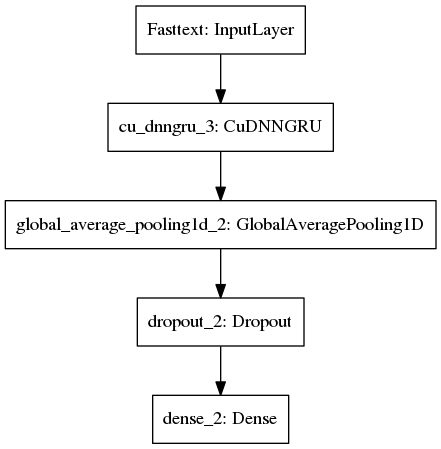

In [7]:

model = ElmoModel(
    max_length,  
    **{
        **classifier_args,
        **{
            "fasttext_model": fasttext_model,
            "elmo_embedder": None,
        }
    }
)

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer(**optimizer_args), 
              metrics=['accuracy'])

#model.load_weights("../../../models/lstm_elmo.h5")
print(model.summary())
plot_model(model, to_file='model.png')


Image(filename='model.png') 

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint('/tmp/lstm_model.h5', save_best_only=True, monitor='val_acc', verbose=1)
early_stopper = EarlyStopping(monitor='val_acc', patience=10)


model.fit(text_train, y_train, 
          callbacks=[checkpointer, early_stopper],
          validation_data=(text_dev, y_dev), 
          epochs=100, verbose=1,
          batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 1s 316us/step - loss: 0.6541 - acc: 0.6264 - val_loss: 0.6245 - val_acc: 0.6580

Epoch 00001: val_acc improved from -inf to 0.65800, saving model to /tmp/lstm_model.h5
Epoch 2/100
4500/4500 [==============================] - 1s 195us/step - loss: 0.5379 - acc: 0.7362 - val_loss: 0.5163 - val_acc: 0.7380

Epoch 00002: val_acc improved from 0.65800 to 0.73800, saving model to /tmp/lstm_model.h5
Epoch 3/100
4500/4500 [==============================] - 1s 192us/step - loss: 0.4866 - acc: 0.7631 - val_loss: 0.4931 - val_acc: 0.7700

Epoch 00003: val_acc improved from 0.73800 to 0.77000, saving model to /tmp/lstm_model.h5
Epoch 4/100
4500/4500 [==============================] - 1s 187us/step - loss: 0.4595 - acc: 0.7882 - val_loss: 0.4891 - val_acc: 0.7680

Epoch 00004: val_acc did not improve from 0.77000
Epoch 5/100
4500/4500 [==============================] - 1s 213us/step - loss: 0.435

In [9]:
from hate.utils import print_evaluation
print("{} -- \n\n".format(model.display_name))
print("Evaluación sobre dev")

model.load_weights(checkpointer.filepath)

print_evaluation(model, text_dev, y_dev)
print("\nEvaluación sobre test")

print_evaluation(model, text_test, y_test)

CuDNNGRU with avg pooling consuming Fasttext_1:0 -- 


Evaluación sobre dev
500/500 [==============================] - 0s 101us/step
Loss           : 0.4785
Accuracy       : 0.7800
Precision(1)   : 0.7373
Precision(1)   : 0.8182
Precision(avg) : 0.7777

Recall(1)      : 0.7838
Recall(0)      : 0.7770
Recall(avg)    : 0.7804

F1(1)          : 0.7598
F1(0)          : 0.7970
F1(avg)        : 0.7784

Evaluación sobre test
1600/1600 [==============================] - 0s 105us/step
Loss           : 0.5219
Accuracy       : 0.7306
Precision(1)   : 0.6509
Precision(1)   : 0.8026
Precision(avg) : 0.7267

Recall(1)      : 0.7485
Recall(0)      : 0.7181
Recall(avg)    : 0.7333

F1(1)          : 0.6963
F1(0)          : 0.7580
F1(avg)        : 0.7271


# Sin fasttext

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Elmo (InputLayer)            (None, 50, 1024)          0         
_________________________________________________________________
cu_dnngru_5 (CuDNNGRU)       (None, 50, 256)           984576    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 984,833
Trainable params: 984,833
Non-trainable params: 0
_________________________________________________________________
None


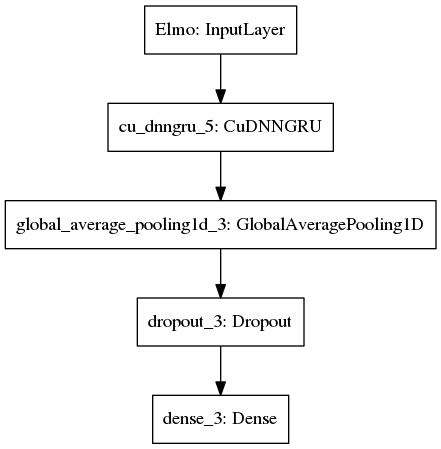

In [10]:
model = ElmoModel(
    max_length,  
    **{
        **classifier_args,
        **{
            "fasttext_model": None,
            "elmo_embedder": elmo_embedder,
        }
    }
)

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer(**optimizer_args), 
              metrics=['accuracy'])


#model.load_weights("../../../models/lstm_elmo.h5")
print(model.summary())
plot_model(model, to_file='model.png')


Image(filename='model.png') 

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint('/tmp/lstm_model.h5', save_best_only=True, monitor='val_acc', verbose=1)
early_stopper = EarlyStopping(monitor='val_acc', patience=10)


model.fit(text_train, y_train, 
          callbacks=[checkpointer, early_stopper],
          validation_data=(text_dev, y_dev), 
          epochs=100, verbose=1,
          batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 2s 443us/step - loss: 0.6806 - acc: 0.6316 - val_loss: 0.5184 - val_acc: 0.7480

Epoch 00001: val_acc improved from -inf to 0.74800, saving model to /tmp/lstm_model.h5
Epoch 2/100
4500/4500 [==============================] - 1s 303us/step - loss: 0.4948 - acc: 0.7591 - val_loss: 0.4566 - val_acc: 0.7960

Epoch 00002: val_acc improved from 0.74800 to 0.79600, saving model to /tmp/lstm_model.h5
Epoch 3/100
4500/4500 [==============================] - 1s 315us/step - loss: 0.4270 - acc: 0.8060 - val_loss: 0.4237 - val_acc: 0.8080

Epoch 00003: val_acc improved from 0.79600 to 0.80800, saving model to /tmp/lstm_model.h5
Epoch 4/100
4500/4500 [==============================] - 1s 323us/step - loss: 0.3784 - acc: 0.8271 - val_loss: 0.4238 - val_acc: 0.8080

Epoch 00004: val_acc did not improve from 0.80800
Epoch 5/100
4500/4500 [==============================] - 1s 314us/step - loss: 0.351

In [12]:
from hate.utils import print_evaluation
print("{} -- \n\n".format(model.display_name))
print("Evaluación sobre dev")

model.load_weights(checkpointer.filepath)

print_evaluation(model, text_dev, y_dev)
print("\nEvaluación sobre test")

print_evaluation(model, text_test, y_test)

CuDNNGRU with avg pooling consuming Elmo_1:0 -- 


Evaluación sobre dev
500/500 [==============================] - 0s 176us/step
Loss           : 0.5946
Accuracy       : 0.8280
Precision(1)   : 0.8269
Precision(1)   : 0.8288
Precision(avg) : 0.8278

Recall(1)      : 0.7748
Recall(0)      : 0.8705
Recall(avg)    : 0.8226

F1(1)          : 0.8000
F1(0)          : 0.8491
F1(avg)        : 0.8246

Evaluación sobre test
1600/1600 [==============================] - 0s 189us/step
Loss           : 0.9377
Accuracy       : 0.7388
Precision(1)   : 0.6753
Precision(1)   : 0.7883
Precision(avg) : 0.7318

Recall(1)      : 0.7091
Recall(0)      : 0.7606
Recall(avg)    : 0.7349

F1(1)          : 0.6918
F1(0)          : 0.7742
F1(avg)        : 0.7330


Ok! Uhmmmm no queda claro si ELMo